<a href="https://colab.research.google.com/github/daniel-gonzalez-cedre/school/blob/master/nd/TA/discernment-lectures/computer-vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<IPython.core.display.Javascript object>

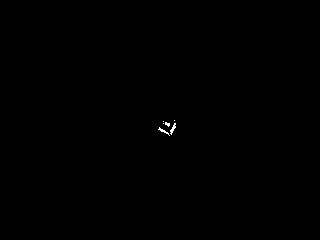

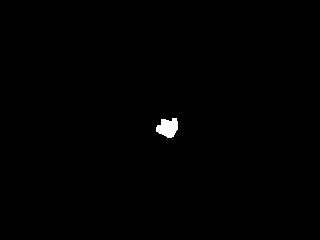

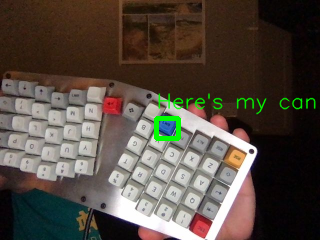

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [10]:
# Computer Vision Course (CSE 40535/60535)
# University of Notre Dame, Fall 2019
# ----------------------------------------------------------------
# Adam Czajka, Andrey Kuehlkamp, September 2017-2019

# Below are your tasks for today. Present your solutions to the instructor / TA in class.
# If you need more time, finish your codes at home and upload them to your SAKAI Dropbox by Wednesday, Sept. 18, 11:59 pm.
#
# Task 1 (2 points):
# - Select one candy that you want to track and set the RGB
#   channels to the selected ranges (using hsvSelection.py).
# - Check if HSV color space works better. Can you ignore one or two
#   channels when working in HSV color space ("ignore" = set the lower bound to 0 and upper bound to 255)? Is so, why?
# - Try to track candies of different colors (blue, yellow, green).
# - What happens when you put two candies of the same color into a video frame?
# - If you have not presented your solution to the instructor in class, upload your code solving this task to your SAKAI Dropbox as colorTracking1.py
#
# Task 2 (1 point):
# - Adapt your code to track multiple candies of *the same* color simultaneously.
# - Upload your solution to your SAKAI Dropbox as colorTracking2.py
#
# Task 3 (2 points):
# - Adapt your code to track multiple candies of *different* colors simultaneously.
# - Upload your solution to your SAKAI Dropbox as colorTracking3.py

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

#cam = cv2.VideoCapture(0)

while (True):
  #retval, img = cam.read()
  img = cv2.imread(take_photo(), cv2.IMREAD_UNCHANGED)

  # rescale the input image if it's too large
  res_scale = 0.5
  img = cv2.resize(img, (0,0), fx = res_scale, fy = res_scale)

  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # RED
  red_lower = np.array([168, 180, 100])
  red_upper = np.array([178, 235, 150])

  # GREEN
  green_lower = np.array([66, 150, 50])
  green_upper = np.array([79, 255, 150])

  # YELLOW
  yellow_lower = np.array([15, 175, 130])
  yellow_upper = np.array([30, 255, 255])

  # BLUE
  blue_lower = np.array([103, 180, 100])
  blue_upper = np.array([115, 250, 170])

  lower = [blue_lower]
  upper = [blue_upper]
  #lower = [green_lower, yellow_lower, blue_lower]
  #upper = [green_upper, yellow_upper, blue_upper]

  objmask = sum(cv2.inRange(hsv, l, u) for l in lower for u in upper)

  #######################################################
  # you may use this for debugging
  cv2_imshow(objmask) #Binary image

  # Resulting binary image may have large number of small objects.
  # We can use morphological operations to remove these unnecessary elements:
  kernel = np.ones((5,5), np.uint8)
  objmask = cv2.morphologyEx(objmask, cv2.MORPH_CLOSE, kernel=kernel)
  objmask = cv2.morphologyEx(objmask, cv2.MORPH_DILATE, kernel=kernel)
  
  # Display image after morphological operations
  cv2_imshow(objmask)

  # find connected components
  cc = cv2.connectedComponents(objmask)
  ccimg = cc[1].astype(np.uint8)

  # find contours of these objects:
  contours, hierarchy = cv2.findContours(ccimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # You may display the countour points if you want:
  # cv2.drawContours(img, contours, -1, (255,0,0), 3)
  # ignore bounding boxes smaller than "minObjectSize"
  minObjectSize = 10;

  def func(args):
    x, y, w, h = args
    return w*h

  just_one_box = True
  if just_one_box:
    if contours:
      contour = max(contours, key=lambda c: func(cv2.boundingRect(c)))
      x, y, w, h = cv2.boundingRect(contour)

      if w > minObjectSize or h > minObjectSize:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 3)
        cv2.putText(img,                        # image
                    "Here's my candy!",         # text
                    (x, y-10),                  # start position
                    cv2.FONT_HERSHEY_SIMPLEX,   # font
                    0.7,                        # size
                    (0, 255, 0),                # BGR color
                    1,                          # thickness
                    cv2.LINE_AA)                # type of line

        cv2_imshow(img) # Bounding box image
  else:
    for contour in contours:
      contour = max(contours, key=lambda c: func(cv2.boundingRect(c)))
      x, y, w, h = cv2.boundingRect(contour)

      if w > minObjectSize or h > minObjectSize:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 3)
        cv2.putText(img,                        # image
                    "Here's my candy!",         # text
                    (x, y-10),                  # start position
                    cv2.FONT_HERSHEY_SIMPLEX,   # font
                    0.7,                        # size
                    (0, 255, 0),                # BGR color
                    1,                          # thickness
                    cv2.LINE_AA)                # type of line

        cv2_imshow(img) # Bounding box image
#  action = cv2.waitKey(1)
#  if action == 27:
#    break